In [78]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [80]:
df_train=pd.read_csv('/kaggle/input/titanic/train.csv')

In [81]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [82]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [83]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


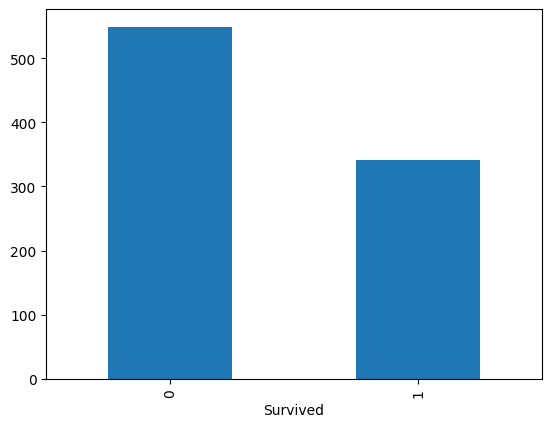

In [84]:
df_train['Survived'].value_counts().plot(kind='bar')
plt.show()

In [85]:
feat_n=['PassengerId','Age','SibSp','Parch','Fare']
feat_o=['Pclass']
feat_c=['Name','Sex','Ticket','Cabin','Embarked']

In [86]:
for n in feat_o:
    print(df_train[n].value_counts())

Pclass
3    491
1    216
2    184
Name: count, dtype: int64


In [87]:
for c in feat_c:
    print(df_train[c].value_counts())

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64
Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1

# New features to create: 
* Family groups - From ticket number. Although ticket numbers are not all numeric
* number of cabins - done
* First name and last name - how to convert this in to a numeric?
* Positioning on the ship - Cabin number? There are several missing points. Is this missing at random?? Split into Class B or C, and door number. 

Challenge: How to convert following into numerics?
* Ticket numbers
* First name and last name or atleast just first name
* GroupSize = same ticket number (what about same first name?)

In [88]:
df_train.shape

(891, 12)

In [89]:
def preprocessdata(df):
    df['Sex']=df['Sex'].replace({'male':0,'female':1})

    df[['FirstName','LastName']]=df['Name'].str.split(',',expand=True)
    df_fname=df['FirstName'].value_counts().to_frame().reset_index()
    df_fname.rename(columns={'count':'NameFreq'},inplace=True)
    df=pd.merge(df,df_fname,on='FirstName')
    df.drop(columns=['Name','FirstName','LastName'],inplace=True)

    # df['Ticket']=df['Ticket'].astype(str)
    df_tics=df['Ticket'].value_counts().to_frame().reset_index()
    df_tics.rename(columns={'count':'TicketFreq'},inplace=True)
    df_tics['Ticket']=df_tics['Ticket'].astype(str)
    df=pd.merge(df,df_tics,on='Ticket')
    df.drop(columns='Ticket',inplace=True)

    df['nCabins']=df['Cabin'].str.split(' ',expand=True).notnull().sum(axis=1)
    # df['CabinChar']=df['Cabin'].str[0]
    # df['CabinNum']=df['Cabin'].str[1:]

    df_cabins=df['Cabin'].value_counts().to_frame().reset_index()
    df_cabins.rename(columns={'count':'CabinFreq'},inplace=True)
    df=pd.merge(df,df_cabins,on='Cabin',how='left')
    df.drop(columns='Cabin',inplace=True)
    df['CabinFreq']=df['CabinFreq'].fillna(0)
    print('How to separate cabin name and num if there are multiple cabins reported?')

    df=pd.get_dummies(df, columns=['Embarked'],drop_first=True)

#     df['LogFare']=np.log(df['Fare'])
#     df.drop(columns='Fare',inplace=True)

    df['Age']=df['Age'].fillna(np.mean(df['Age']))
    df['LogAge']=np.log(df['Age'])
    df.drop(columns='Age',inplace=True)
    
    return df


df_train_orig=df_train.copy()
df_train=preprocessdata(df_train)

How to separate cabin name and num if there are multiple cabins reported?


/tmp/ipykernel_33/1023242590.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex']=df['Sex'].replace({'male':0,'female':1})


In [90]:
df_train.shape

(891, 14)

In [91]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,NameFreq,TicketFreq,nCabins,CabinFreq,Embarked_Q,Embarked_S,LogAge
0,1,0,3,0,1,0,7.2500,2,1,0,0.0,False,True,3.091042
1,2,1,1,1,1,0,71.2833,1,1,1,1.0,False,False,3.637586
2,3,1,3,1,0,0,7.9250,1,1,0,0.0,False,True,3.258097
3,4,1,1,1,1,0,53.1000,2,2,1,2.0,False,True,3.555348
4,5,0,3,0,0,0,8.0500,2,1,0,0.0,False,True,3.555348


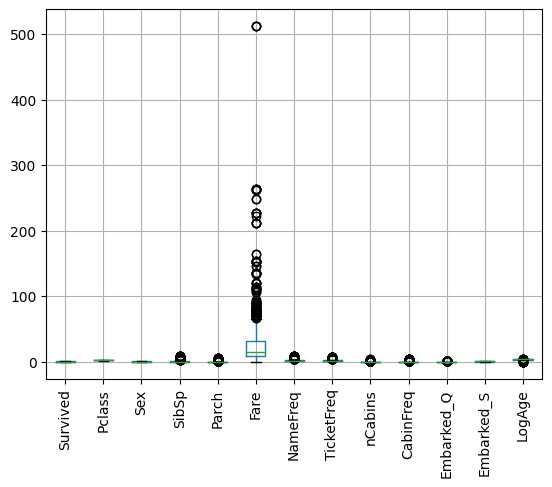

In [92]:
df_train.drop(columns='PassengerId').boxplot()
plt.xticks(rotation=90)
plt.show()

In [93]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   NameFreq     891 non-null    int64  
 8   TicketFreq   891 non-null    int64  
 9   nCabins      891 non-null    int64  
 10  CabinFreq    891 non-null    float64
 11  Embarked_Q   891 non-null    bool   
 12  Embarked_S   891 non-null    bool   
 13  LogAge       891 non-null    float64
dtypes: bool(2), float64(3), int64(9)
memory usage: 85.4 KB


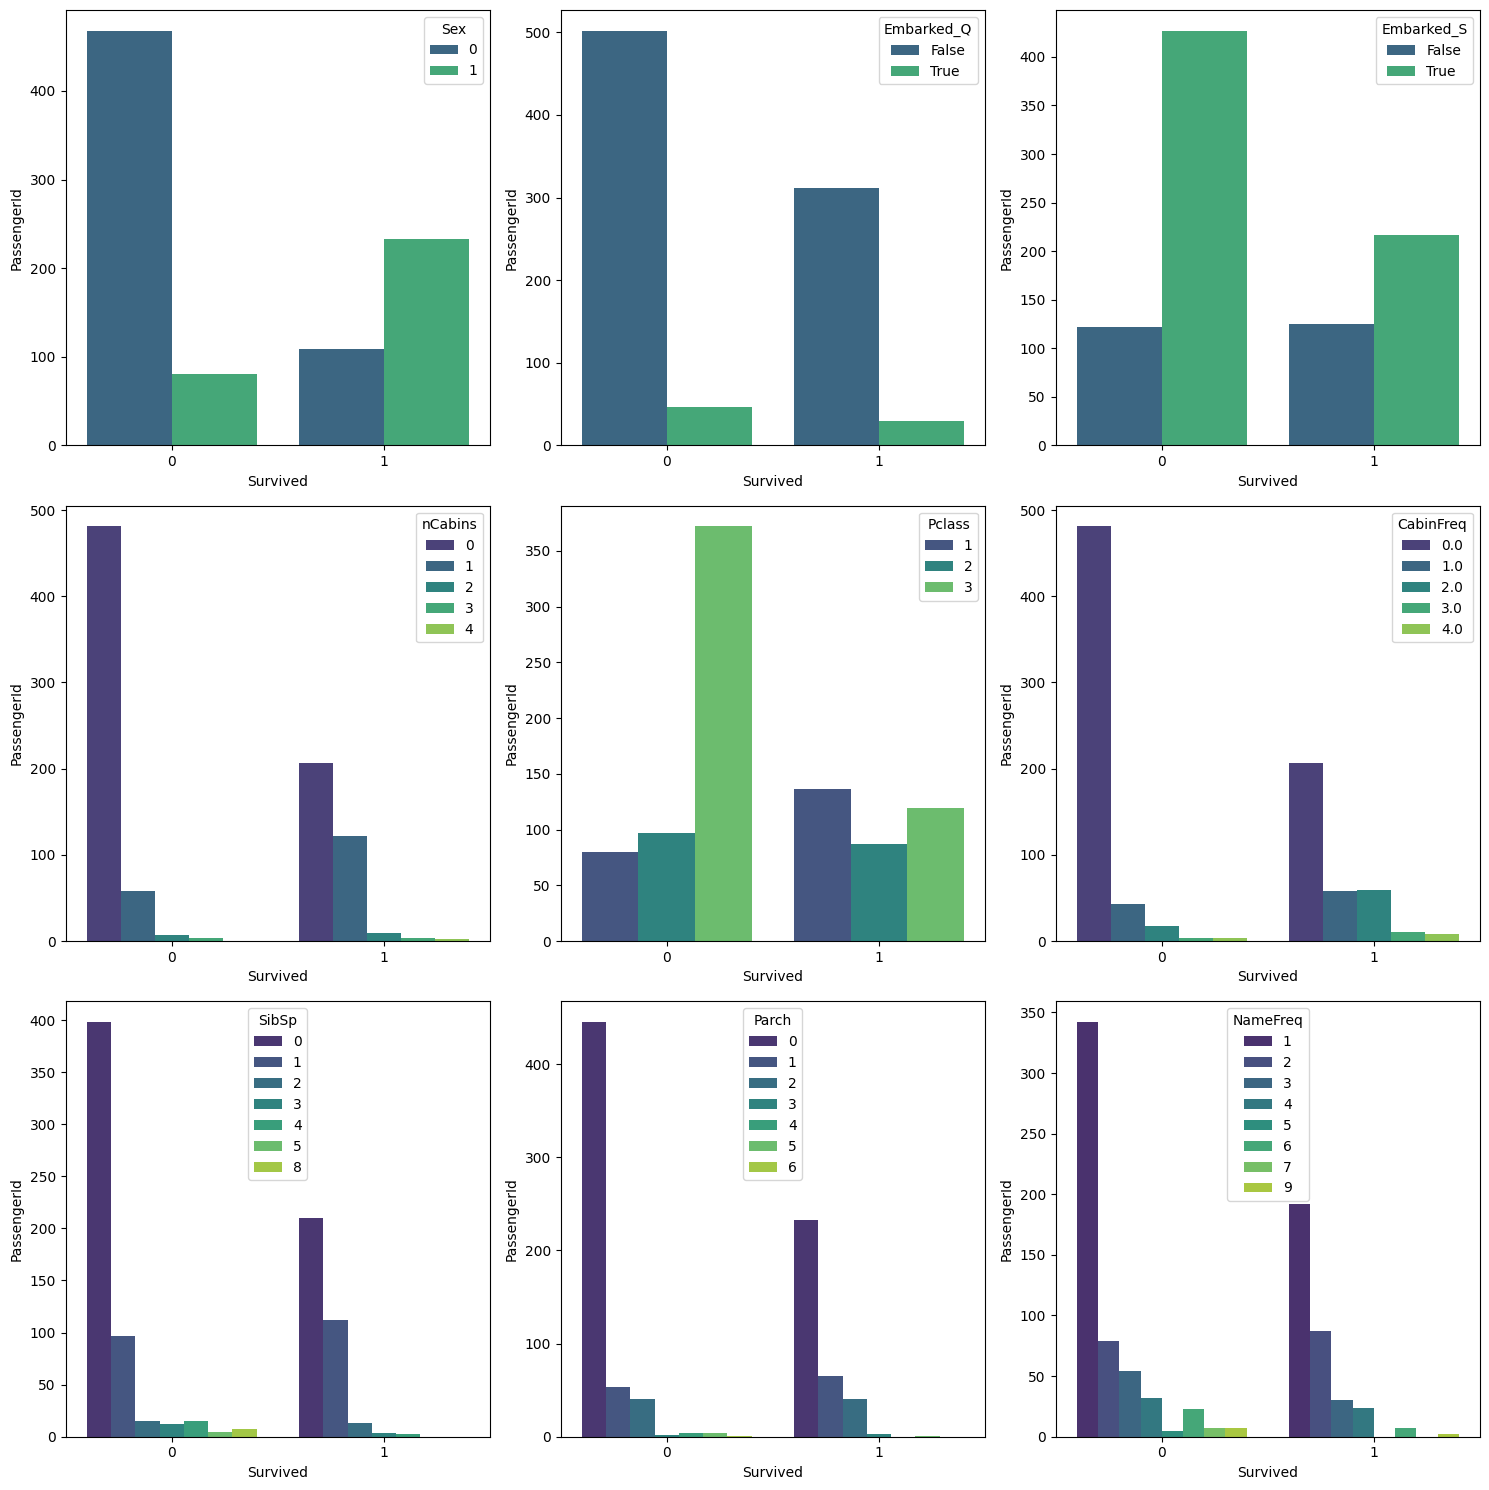

In [94]:
plt.figure(figsize=(15,15))
feat_bin=['Sex','Embarked_Q','Embarked_S','nCabins','Pclass','CabinFreq','SibSp','Parch','NameFreq']
# fig,ax=plt.subplots(nows=3,nCols=3)
for inx,f in enumerate(feat_bin):
    plt.subplot(3,3,inx+1)
    sns.barplot(data=df_train.groupby(['Survived',f])['PassengerId'].\
                agg('count').reset_index(),x='Survived',y='PassengerId',hue=f,palette='viridis')
    
plt.tight_layout()
plt.show()

# Machine Learning

Cabins: Create as many columns as max number of cabins
split each cabin design into name and number
fill noncabins with 0
how to separate missing info with noncabins info?

In [95]:
X_train=df_train.drop(columns=['PassengerId','Survived'])
y_train=df_train['Survived']

In [96]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   NameFreq     891 non-null    int64  
 8   TicketFreq   891 non-null    int64  
 9   nCabins      891 non-null    int64  
 10  CabinFreq    891 non-null    float64
 11  Embarked_Q   891 non-null    bool   
 12  Embarked_S   891 non-null    bool   
 13  LogAge       891 non-null    float64
dtypes: bool(2), float64(3), int64(9)
memory usage: 85.4 KB


In [97]:
X_train

,Pclass,Sex,SibSp,Parch,Fare,NameFreq,TicketFreq,nCabins,CabinFreq,Embarked_Q,Embarked_S,LogAge
0,3,0,1,0,7.2500,2,1,0,0.0,False,True,3.091042
1,1,1,1,0,71.2833,1,1,1,1.0,False,False,3.637586
2,3,1,0,0,7.9250,1,1,0,0.0,False,True,3.258097
3,1,1,1,0,53.1000,2,2,1,2.0,False,True,3.555348
4,3,0,0,0,8.0500,2,1,0,0.0,False,True,3.555348
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,0,13.0000,1,1,0,0.0,False,True,3.295837
887,1,1,0,0,30.0000,3,1,1,1.0,False,True,2.944439
888,3,1,1,2,23.4500,2,2,0,0.0,False,True,3.391117
889,1,0,0,0,30.0000,1,1,1,1.0,False,False,3.258097


https://stackoverflow.com/questions/36532497/standardscaler-valueerror-input-contains-nan-infinity-or-a-value-too-large-fo

In [98]:
np.where(np.isinf(X_train))


(array([], dtype=int64), array([], dtype=int64))

In [99]:
X_train.loc[179]

Pclass               3
Sex                  0
SibSp                0
Parch                0
Fare               0.0
NameFreq             1
TicketFreq           4
nCabins              0
CabinFreq          0.0
Embarked_Q       False
Embarked_S        True
LogAge        3.583519
Name: 179, dtype: object

In [101]:
from sklearn.preprocessing import StandardScaler

def scaledata(X_in,scaler):
    X_in=scaler.transform(X_in)
    return X_in
        
stdsc=StandardScaler().fit(X_train)
X_train=scaledata(X_train,stdsc)



In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

logreg=LogisticRegression()

scores=cross_validate(logreg,X_train,y_train,cv=5)

In [105]:
scores

{'fit_time': array([0.01217628, 0.00556779, 0.00502849, 0.00487232, 0.00497389]),
 'score_time': array([0.00140381, 0.00110817, 0.00106311, 0.00104952, 0.0010283 ]),
 'test_score': array([0.80446927, 0.78651685, 0.79775281, 0.79775281, 0.84831461])}